In [1]:
pip install -q *.whl numpy matplotlib osparc_filecomms pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pathlib as pl
import json
import zipfile

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas

import osparc
import osparc.api
import osparc_client
import osparc_client.models.file

import tools.maps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
osparc_cfg = osparc.Configuration(host="10.43.103.149.nip.io:8006",
                                  username=os.environ["OSPARC_API_KEY"],
                                  password=os.environ["OSPARC_API_SECRET"])
output_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_OUTPUTS'])
output1_dir_path = output_dir_path / 'output_1'

input_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_INPUTS'])
input1_dir_path = input_dir_path / 'input_1'

map_outputs_file_path = pl.Path('map_outputs.json')

In [4]:
TEST_INPUT_FILES_DIR = 'example_r20211130-ivadomed_dataset'

In [5]:
input_images_dir_path = pl.Path(TEST_INPUT_FILES_DIR)
input_images_paths = list(input_images_dir_path.glob('*.png'))
input_metadata_paths = [path.with_suffix('.json') for path in input_images_paths]

In [6]:
def show_input_files(file_list):
    fig, axes = plt.subplots(1, len(file_list), figsize=(20,10))
    for local_file_path, ax in zip(file_list, axes):
        ax.imshow(mpimg.imread(local_file_path), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
def show_output_files(map_outputs, file_list):
    fig, axes = plt.subplots(1, len(file_list), figsize=(20,10))
 
    for map_output, file_path, ax in zip(map_outputs, file_list, axes):
        with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
            segmented_filename = f'{file_path.stem}_seg-axonmyelin{file_path.suffix}'
            with output_zip.open(segmented_filename) as image_file:
                ax.imshow(mpimg.imread(image_file))
                ax.axis('off')
                
    plt.tight_layout()
    plt.show()

In [8]:
def upload_files(file_list):
    uploaded_files = []
    with osparc.ApiClient(osparc_cfg) as api_client:
        for local_file_path in file_list:
            uploaded_file = osparc.api.FilesApi(api_client).upload_file(                                                                                                                                                                    
                file=pl.Path(local_file_path)                                                                                                                                                                                                       
            )
            uploaded_files.append(uploaded_file)
    return uploaded_files

In [9]:
def create_map_inputs(up_file_list, metadata_file_list):
    map_inputs = []
    for uploaded_file, metadata_file in zip(up_file_list, metadata_file_list):
        metadata = json.loads(metadata_file.read_text())
        map_inputs.append({
            "input": { 
                "InputImage": {
                    "type": "file",
                    "value": json.dumps(uploaded_file.to_dict())
                },
                "PixelSize": {
                    "type": "float",
                    "value": metadata["PixelSize"][0] 
                }
            },
            "output": {
                "Morphometrics": {
                  "type": "file"
                },
                "ProcessedImage": {
                  "type": "file"
                }
            }
        })
    return map_inputs

In [10]:
def process_map_outputs(map_outputs):
    processed_outputs = []
    with osparc.ApiClient(osparc_cfg) as api_client:
        for map_output in map_outputs:
            processed_output = {}
            for probe_name, probe_dict in map_output.items():
                file_dict = json.loads(probe_dict["value"])
                osparc_file = osparc_client.models.file.File(**file_dict)
                processed_output[probe_name]= osparc.api.FilesApi(api_client).download_file(osparc_file.id)
    
            processed_outputs.append(processed_output)
    return processed_outputs

In [11]:
uploaded_files = upload_files(input_images_paths)

# Input images

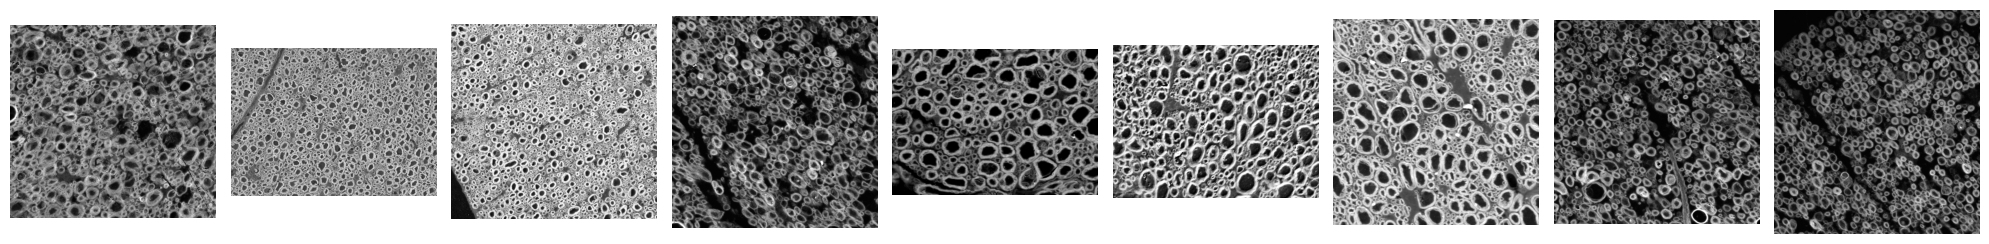

In [12]:
display(Markdown('# Input images'))
show_input_files(input_images_paths)

In [13]:
map_inputs = create_map_inputs(uploaded_files, input_metadata_paths)

In [14]:
map = tools.maps.oSparcFileMap(input1_dir_path/'output_tasks.json', output1_dir_path/'input_tasks.json')
map_outputs = map.evaluate(map_inputs)
map_outputs_file_path.write_text(json.dumps(map_outputs))

5607

In [15]:
map_outputs = json.loads(map_outputs_file_path.read_text())

In [16]:
map_outputs = process_map_outputs(map_outputs)

# Processed Images

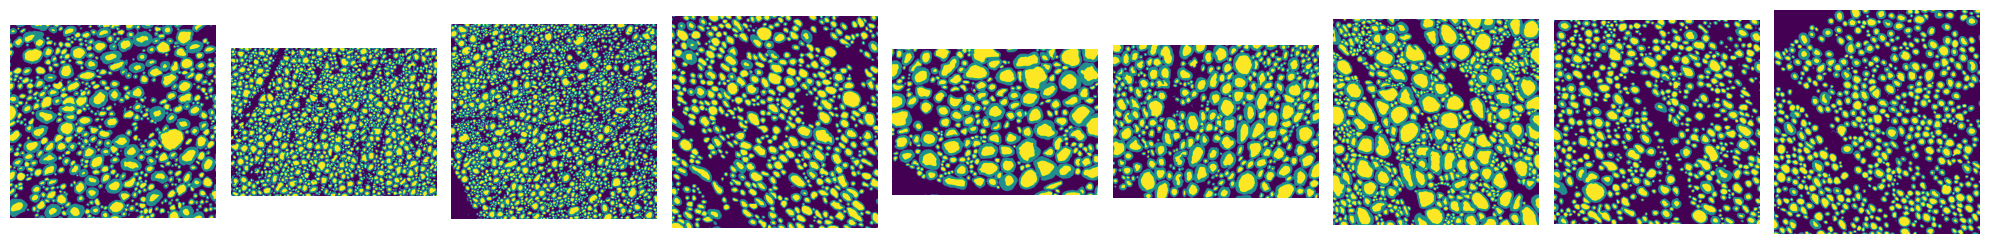

In [17]:
display(Markdown('# Processed Images'))
show_output_files(map_outputs, input_images_paths)

In [18]:
requested_morphometrics = ['axon_diam (um)', 'axon_area (um^2)', 'myelin_thickness (um)', 'myelin_area (um^2)']

# Output Morphometrics

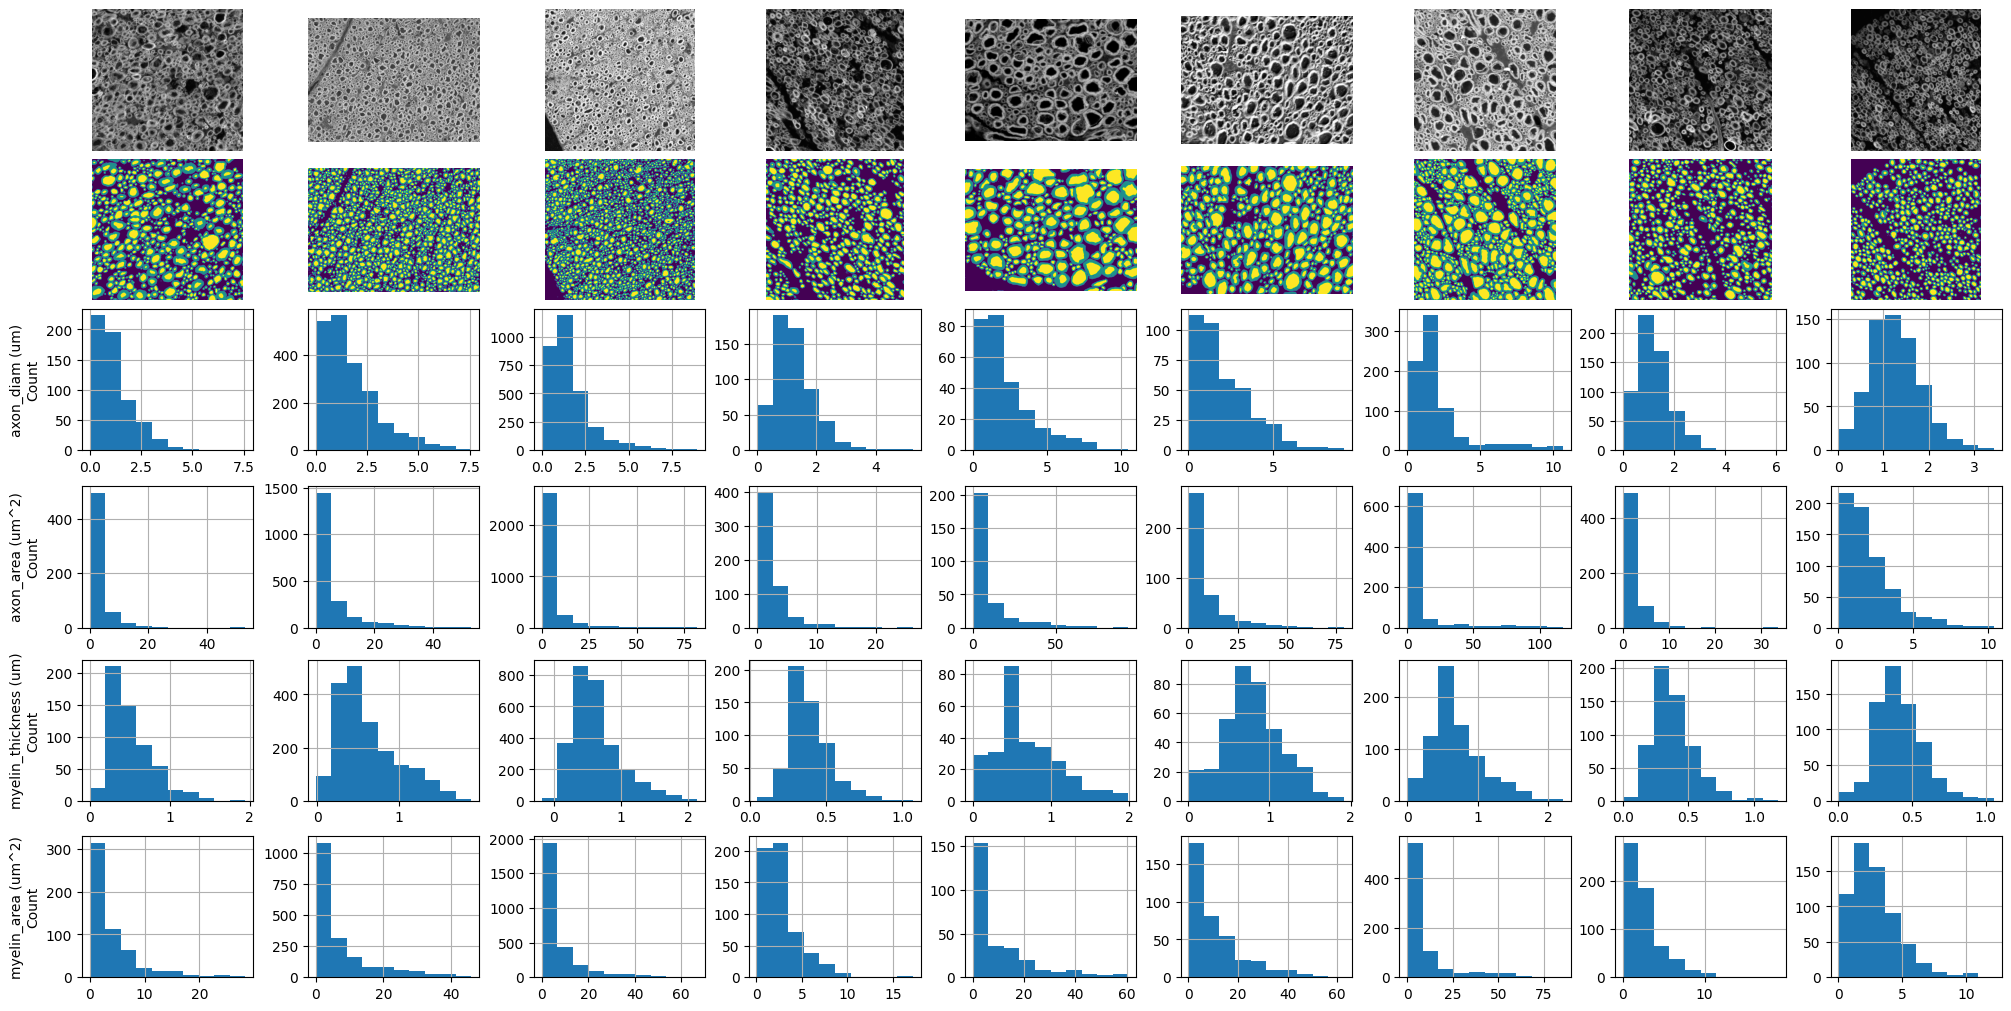

In [19]:
display(Markdown('# Output Morphometrics'))

fig, axes = plt.subplots(len(requested_morphometrics)+2, len(map_outputs), squeeze=False, figsize=(20,2*len(requested_morphometrics)+2), layout="constrained")
for i_axes, (map_output, input_image_path, ax) in enumerate(zip(map_outputs, input_images_paths, axes.transpose())):
    ax[0].imshow(mpimg.imread(input_image_path), cmap='gray')
    ax[0].axis('off')
    ax[0].autoscale(False)
    
    with zipfile.ZipFile(map_output['ProcessedImage']) as output_zip:
        processed_filename = f'{input_image_path.stem}_seg-axonmyelin{input_image_path.suffix}'
        with output_zip.open(processed_filename) as image_file:
            ax[1].imshow(mpimg.imread(image_file))
            ax[1].axis('off')
            ax[1].autoscale(False)
    
    morphometrics_file = map_output['Morphometrics']
    morphometrics = pandas.read_csv(morphometrics_file)
    for i_ax, requested_morphometric in enumerate(requested_morphometrics, 2):
        morphometrics.hist(column=requested_morphometric, ax=ax[i_ax])
        if i_axes == 0:
            ax[i_ax].set_ylabel(f'{requested_morphometric}\nCount')
        ax[i_ax].set_title('')

plt.show()

# Summary Morphometrics

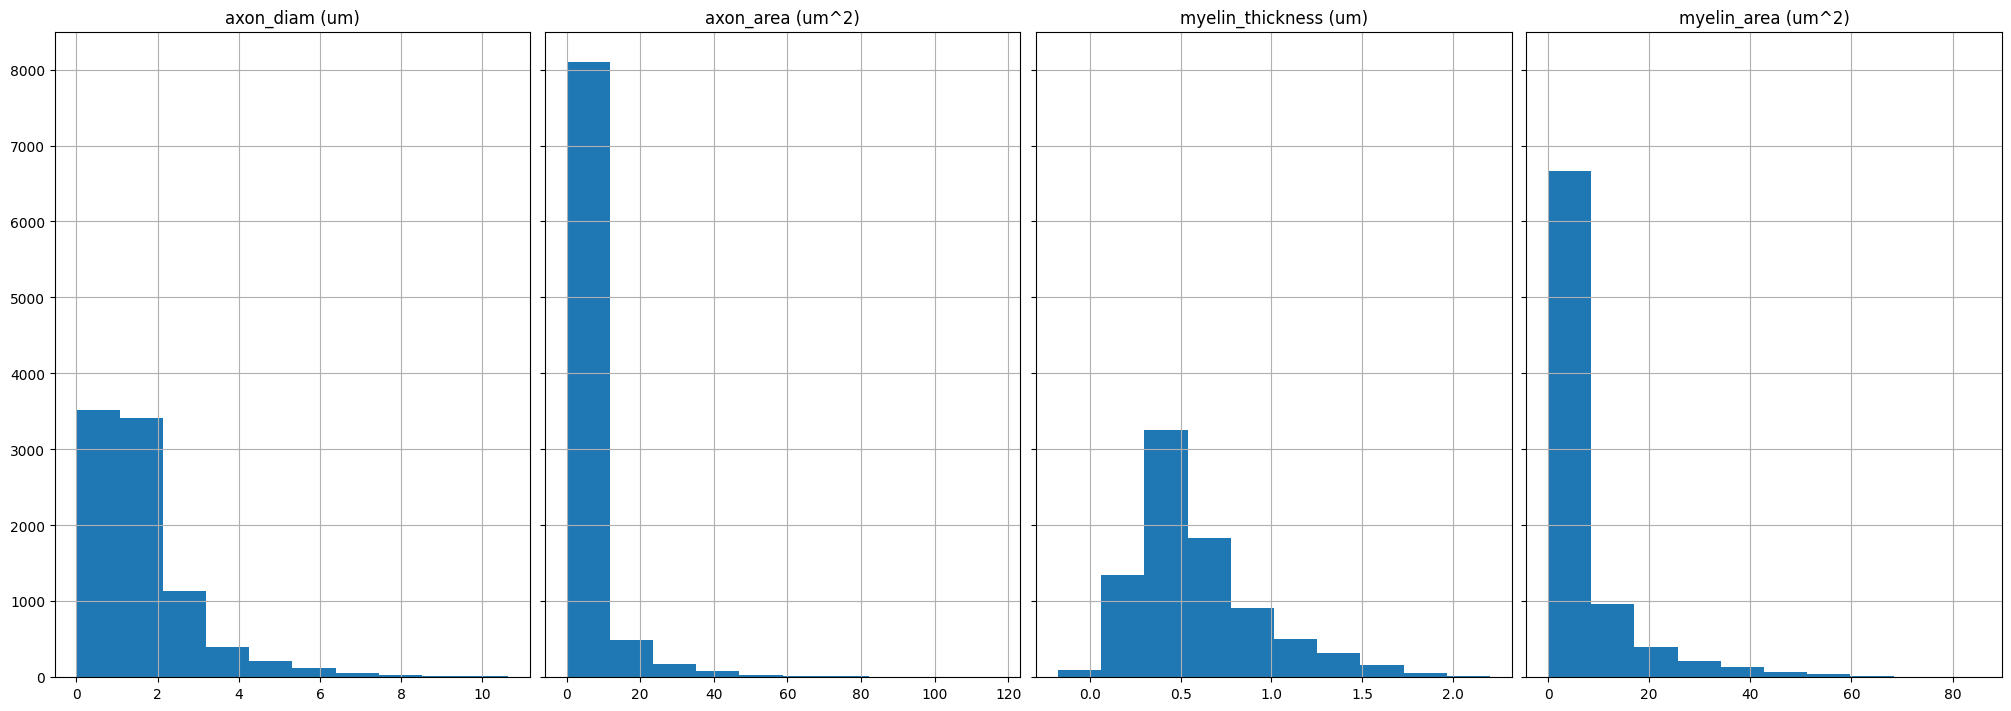

In [20]:
display(Markdown('# Summary Morphometrics'))

summary_data = pandas.concat([pandas.read_csv(map_output['Morphometrics']) for map_output in map_outputs], axis=0, ignore_index=True)

fig, axes = plt.subplots(1, len(requested_morphometrics), sharey=True, squeeze=False, figsize=(20,7), layout="constrained")

for requested_morphometric, ax in zip(requested_morphometrics, axes[0]):
    summary_data.hist(column=requested_morphometric, ax=ax)